__Aim:__ building an extended version of `primekg` that include OMIM phenotypes and genes. 


In __PrimeKG__ there is no __"source"__ dedicated to OMIM (neither [July 2023] nor [Feb 2023] versions). Here, I aim to gather relevant info and append OMIM gene and phenotype links to the current PrimeKG graph. 

__Background / History:__
- \[**explain why this is important**\]
- During my work in another project, I noticed there are no OMIM nodes in the current graph – https://github.com/mims-harvard/PrimeKG/issues/9
- After a discussion with Dr. Marinka Zitnik ([@marinkaz](https://github.com/marinkaz)), she suggested that I can make this work as a pull request to the PrimeKG repo.
- Previously, I aimed to work with OMIM textual information together with Dr. Hadi Amiri ([@amirieb](https://github.com/amirieb)). Thus, scripts I used here also extracts up-to-date textual information from OMIM which can be used for Natural Language Processing (NLP) tasks with OMIM entries.

__Datasets:__
- Mondo Disease Ontology – https://mondo.monarchinitiative.org/
- Human Phenotype Ontology – https://hpo.jax.org/app/
- Online Mendelian Inheritance in Man (OMIM) 

__Tasks:__
- [x] Load a `primeKG` version to be extended.
- [x] Explore `primeKG` and distill relevant information.
- [x] Append/find links between `MONDO`/`HPO` terms and OMIM genes/phenotypes.
- [x] Unify nomenclature to refine the knowledge graph by adding desired relationships.
- [x] Include/keep links between genes and HPO, OMIM, etc.
- [x] Use `KG` TDC data function to build OMIM `KG` – https://github.com/mims-harvard/TDC/pull/207
- [ ] Compare the two graphs, before and after including info from OMIM database.
- \[?\] Upload required data into Harvard Dataverse.
- [ ] Report changes in PrimeKG after extending with OMIM phenotypes / genes.

In [1]:
import re
import pandas as pd
import numpy as np
import igraph as ig
import sys
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn2_circles
from matplotlib_venn import venn3, venn3_circles

# https://blakeaw.github.io/2020-05-25-improve-matplotlib-notebook-inline-res/
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg')

datasets_path = '../datasets'

In [2]:
sys.path.append('..')

from scripts.utils import write_data, read_data
from datasets.processing_scripts import omim_tools
from datasets.processing_scripts.mondo_obo_parser import OBOReader

In [13]:
from tdc.utils.knowledge_graph import KnowledgeGraph, build_KG

## Gather Datasets

In another notebook (see [this link](https://github.com/abearab/PrimeKG/blob/488434dcebc2a8ca7bd53b533edf4cfd93b36bac/datasets/omim/omim-api.ipynb)), I shared scripts and notes about downloading updated version of relevant OMIM data.

### OMIM

In [4]:
data_omim = read_data(f'{datasets_path}/OMIM/OMIM_FULL_May_2023.json.gz')

done in 4.873s


___
Let's see what kind of information is covered in OMIM:

In [5]:
# omim_tools.get_omim_info(data_omim)

In [6]:
# omim_tools.get_omim_phenotype_info(data_omim)

In [7]:
# {k for i,j in omim_tools.get_omim_info(data_omim,'externalLinks') for k in j.keys()}

___

load annotations for OMIM entries

In [8]:
# read mim2gene
mim2gene = pd.read_csv(
    f'{datasets_path}/OMIM/mim2gene.txt',sep='\t',skiprows=5,header=None,dtype=str
)[[0,1,3]].replace(np.nan, '')
mim2gene.columns = ['mimNumber','mimType','geneSymbol']

# read mimTitles
mimTitles = pd.read_csv(
    f'{datasets_path}/OMIM/mimTitles.txt',sep='\t',skiprows=2,header=0,dtype=str
).replace(np.nan, '').rename(columns={'MIM Number':'mimNumber'})
mimTitles = mimTitles[~mimTitles.iloc[:,0].str.contains('#')]
mimTitles = mimTitles.iloc[:,1:]

sanity check

In [9]:
all(mimTitles.mimNumber == mim2gene.mimNumber)

True

In [10]:
mim_meta = mim2gene.copy()

mim_meta['mimLabel'] = ''
mim_meta.loc[mim_meta.geneSymbol != "",'mimLabel'] = mim_meta.loc[mim_meta.geneSymbol != "",'geneSymbol']
mim_meta.loc[mim_meta.geneSymbol == "",'mimLabel'] = mimTitles.loc[mim_meta.geneSymbol == "",'Preferred Title; symbol'].str.split('; ').str[-1]
mim_meta['mimTitle'] = mimTitles['Preferred Title; symbol'].apply(lambda x: '; '.join(x.split('; ')[:-1]))
mim_meta.loc[mim_meta['mimTitle'].eq(''),'mimTitle'] = mim_meta.loc[mim_meta['mimTitle'].eq(''),'mimLabel']

and Phenotypic-Series ...

In [11]:
mimPS_Titles = pd.read_csv(
    f'{datasets_path}/OMIM/OMIM-Phenotypic-Series-Titles-all.tsv',sep='\t',header=0,skiprows=3,dtype=str
)#.replace(np.nan, '').rename(columns={'MIM Number':'mimNumber'})

### PrimeKG 
https://github.com/mims-harvard/PrimeKG#using-primekg

<img src="https://pbs.twimg.com/media/FSWtqpVXMAA5Rui?format=jpg&name=medium" width=500>

___

In [15]:
# wget -O kg.csv https://dataverse.harvard.edu/api/access/datafile/6180620

# f'{datasets_path}/kg.csv.gz'

___
[@ayushnoori](https://github.com/ayushnoori) comment ([link](https://github.com/mims-harvard/PrimeKG/pull/12#issuecomment-1871463218)):
> - May you please run `append_omim.ipynb` again but use `auxillary/kg_raw.csv`? 
>   - This is the KG before we take the largest connected component (please see `build_graph.ipynb`), and it is best to add new edges to the KG before taking the LCC so we don't unnecessarily lose any nodes. 
>   - This may resolve the `omim_genes_missing` problem that you note in `append_omim.ipynb`.

In [22]:
def read_primekg(filepath):
    df = pd.read_csv(filepath, low_memory=False)
    kg = KnowledgeGraph(df)
    return kg

In [26]:
primekg = read_primekg(f'{datasets_path}/auxillary/kg_raw.csv.gz')

In [30]:
primekg.df.columns.to_list()

['relation',
 'display_relation',
 'x_id',
 'x_type',
 'x_name',
 'x_source',
 'y_id',
 'y_type',
 'y_name',
 'y_source']

### Mondo Disease Ontology

> Stable release versions
> - http://purl.obolibrary.org/obo/mondo.obo
> - http://purl.obolibrary.org/obo/mondo.json
> - http://purl.obolibrary.org/obo/mondo.owl



<!-- > ##### Rare Disease analysis in Mondo
To answer the question of ‘How many rare diseases are there?’ we analyzed terms in Mondo to get a total count of Rare Diseases as defined in Mondo Disease Ontology (Mondo).
> - https://mondo.monarchinitiative.org/pages/analysis/
 -->
 
<!-- - https://mondo.monarchinitiative.org/
- https://github.com/monarch-initiative/mondo
- https://obofoundry.org/ontology/mondo -->

<!-- https://github.com/monarch-initiative/mondo/releases/tag/v2023-07-03 -->

<!-- http://aber-owl.net/ontology/MONDO/#/Download

    Description	A global community effort to harmonize multiple disease resources to yield a coherent merged ontology.

    Version	
    Release date	2023-02-13T12:31:28.980986Z
 -->

I'm using this code to parse mondo `obo` file – https://github.com/mims-harvard/PrimeKG/blob/main/datasets/processing_scripts/mondo_obo_parser.py

In [32]:
pth = f"{datasets_path}/mondo/mondo.obo"
data_mondo = [*iter(OBOReader(pth))]

closeMatch not added for: property_value: closeMatch http://purl.bioontology.org/ontology/ICD10CM/Q82.2


In [33]:
mondo_terms = pd.DataFrame([{'id':x.item_id, 
                             'name':x.name, 
                             'definition':x.definition,
                             'is_obsolete':x.is_obsolete,
                             'xrefs':str(x.xrefs).replace('{','').replace('}',''),
                             'replacement_id': x.replaced_by} for x in data_mondo])

print(mondo_terms.shape[0], "total terms")
print(mondo_terms.query('is_obsolete==False').shape[0], 'not obsolete')

26508 total terms
23314 not obsolete


### HPO

- HPO toolkit – https://github.com/TheJacksonLaboratory/hpo-toolkit
- pyHPO – https://pypi.org/project/pyhpo/ | https://centogene.github.io/pyhpo/
> A Python library to work with, analyze, filter and inspect the Human Phenotype Ontology

<!-- If we want to replace Mondo with HPO, we need Mondo-HPO links and maybe Mondo-OMIM and Mondo-gene relationships.  -->

In [34]:
from pyhpo import Ontology

# initilize the Ontology ()
ont = Ontology()

In [35]:
ont_df = ont.to_dataframe()

In [36]:
def get_omim_for_hpo_term(hpoid):
    return {str(x.toJSON(verbose = True)['id']) for x in Ontology.get_hpo_object(hpoid).omim_diseases}

## Extract relevant info

### MONDO terms with OMIM / OMIMPS links

In [37]:
mondo_omim_terms = mondo_terms[mondo_terms.xrefs.str.contains('OMIM:')].reset_index(drop=True)
mondo_omim_terms['omim'] = mondo_omim_terms.xrefs.apply(lambda x: re.findall("OMIM:[0-9]+",x)[0])
mondo_omim_terms = mondo_omim_terms[['id','omim']]

In [38]:
mondo_omimps_terms = mondo_terms[mondo_terms.xrefs.str.contains('OMIMPS:')].reset_index(drop=True)
mondo_omimps_terms['omimps'] = mondo_omimps_terms.xrefs.apply(lambda x: re.findall("OMIMPS:[0-9]+",x)[0])
mondo_omimps_terms = mondo_omimps_terms[['id','omimps']]

### Evaluate OMIM info in MONDO

#### Overlap all OMIM IDs and OMIM IDs in MONDO.

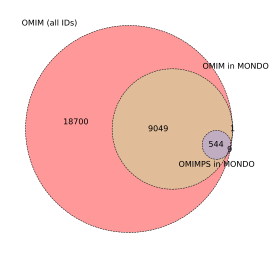

In [39]:
fig, ax = plt.subplots(1, 1,figsize=(4,4),)
subsets = [
    set(mim2gene.mimNumber), 
    set(mondo_omim_terms['omim'].str.replace('OMIM:','').astype(int).astype(str)),
    set(mondo_omimps_terms['omimps'].str.replace('OMIMPS:','').astype(int).astype(str))
]


p = venn3(
    subsets,
    set_labels=(
        'OMIM (all IDs)',
        'OMIM in MONDO',
        'OMIMPS in MONDO'
    ),
    set_colors=('r', 'g', 'b'), 
    # alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn3_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);

fig.tight_layout()
plt.show()

#### Check OMIM gene entries in Mondo

In [41]:
mim2gene.reset_index().set_index('mimNumber').loc[
    list(
        set(mondo_omim_terms.omim.str.replace('OMIM:','').astype(int).astype(str)) & set(mim2gene.mimNumber)
   ),:
].groupby('mimType').size()

mimType
gene                           2
moved/removed                119
phenotype                   7852
predominantly phenotypes    1620
dtype: int64

In [42]:
mim2gene.reset_index().set_index('mimNumber').loc[
    list(
        set(mondo_omimps_terms.omimps.str.replace('OMIMPS:','').astype(int).astype(str)) & set(mim2gene.mimNumber)
   ),:
].groupby('mimType').size()

mimType
moved/removed                 2
phenotype                   549
predominantly phenotypes      2
dtype: int64

<div class="alert alert-block alert-info"> <b>Conclusion:</b> OMIM gene entries are not covered by MONDO .</div>

### Compare Mondo with PrimeKG 

#### OMIM in Mondo

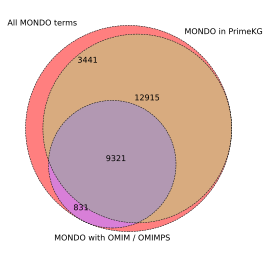

In [46]:
fig, ax = plt.subplots(1, 1,figsize=(4,4),)
subsets = [
    set(mondo_terms.id.astype(int).astype(str)),
    set(primekg.get_nodes_by_source('MONDO').id), 
    set(pd.concat([mondo_omim_terms, mondo_omimps_terms]).id.astype(int).astype(str))
]

p = venn3(
    subsets,
    set_labels=(
        'All MONDO terms',
        'MONDO in PrimeKG',
        'MONDO with OMIM / OMIMPS'
    ),
    set_colors=('r', 'g', 'b'), 
    alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn3_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);



fig.tight_layout()
plt.show()

<div class="alert alert-block alert-warning"> <b>Note:</b> This is most likely cuased by MONDO version difference since I downloaded MONDO datasets myself and that can be different from what has been used in PrimeKG. </div>

#### OMIMPS in OMIM vs. MONDO

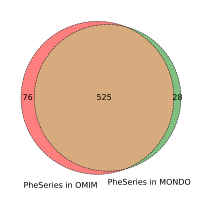

In [47]:
fig, ax = plt.subplots(1, 1,figsize=(3,3),)
subsets = [
    set(omim_tools.get_omim_phenotype_info(data_omim,'phenotypicSeriesNumber').phenotypicSeriesNumber),
    set(mondo_omimps_terms.omimps.str.replace('OMIMPS:','PS'))
]

p = venn2(
    subsets,
    set_labels=(
        'PheSeries in OMIM',
        'PheSeries in MONDO',
        # 'PheSeries in MONDO',
    ),
    set_colors=('r', 'g'), 
    alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn2_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);



fig.tight_layout()
plt.show()

## Build OMIM knowledge graph

Here, I'm mimicking __PrimeKG__'s dataframe format to build an extendable graph from gathered OMIM information.

___
I added some generalizable feature to TDC during this work – https://github.com/mims-harvard/TDC/pull/207

Here, I'm loading functions to handle primeKG data and extend it with OMIM entries.

### 1. Mondo-OMIM links

#### 1.1 OMIM

In [101]:
Mondo_OMIM_kg = build_KG(
    indices = mondo_omim_terms.index,
    relation = 'mim_disease',
    display_relation= 'linked to',

    x_id = mondo_omim_terms['omim'].str.replace('OMIM:','').astype(int),
    x_type = '',
    x_name = '',
    x_source = 'OMIM',

    y_id = mondo_omim_terms['id'].astype(int),
    y_type = '',
    y_name = '',
    y_source = 'MONDO'
)

remove mims if not in OMIM ...

___
    KeyError: "['620151'] not in index"

In [121]:
Mondo_OMIM_kg.run_query(f'x_id != {620151}')

add `x_name` and `x_type` info

In [124]:
Mondo_OMIM_kg.df['x_name'] = mim_meta.set_index('mimNumber').loc[
    Mondo_OMIM_kg.df.x_id.astype(str).to_list(),
    'mimLabel'
].to_list()

In [127]:
Mondo_OMIM_kg.df['x_type'] = mim_meta.set_index('mimNumber').loc[
    Mondo_OMIM_kg.df.x_id.astype(str).to_list(),
    'mimType'
].to_list()

In [150]:
Mondo_OMIM_kg.df.head()

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
0,mim_disease,linked to,616033,phenotype,MSSGM1,OMIM,208,,,MONDO
1,mim_disease,linked to,218000,phenotype,ACCPN,OMIM,902,,,MONDO
2,mim_disease,linked to,615616,phenotype,ARVD13,OMIM,908,,,MONDO
3,mim_disease,linked to,613090,phenotype,BARTS4B,OMIM,909,,,MONDO
4,mim_disease,linked to,312612,phenotype,RP6,OMIM,910,,,MONDO


#### 1.1 OMIMPS

In [130]:
Mondo_OMIMPS_kg = build_KG(
    indices = mondo_omimps_terms.index,
    relation = 'mim_phenotypic_series_disease',
    display_relation= 'linked to',

    x_id = mondo_omimps_terms['omimps'].str.replace('OMIMPS:','PS'),
    x_type = '',
    x_name = '',
    x_source = 'OMIMPS',

    y_id = mondo_omimps_terms['id'].astype(int),
    y_type = 'phenotypic_series',
    y_name = '',
    y_source = 'MONDO'
)

remove PS ids if not in OMIM ...

In [143]:
Mondo_OMIMPS_kg.df.query(f"x_id not in {mimPS_Titles['Phenotypic Series number'].to_list()}").x_id.to_list()

['PS610799',
 'PS156850',
 'PS616814',
 'PS603513',
 'PS300000',
 'PS117550',
 'PS608808',
 'PS617711',
 'PS105500']

In [144]:
Mondo_OMIMPS_kg.df.shape

(558, 10)

In [145]:
Mondo_OMIMPS_kg.run_query(f"x_id in {mimPS_Titles['Phenotypic Series number'].to_list()}")

In [146]:
Mondo_OMIMPS_kg.df.shape

(549, 10)

add `x_name` info

In [147]:
Mondo_OMIMPS_kg.df['x_name'] = mimPS_Titles.set_index(['Phenotypic Series number']).loc[
    Mondo_OMIMPS_kg.df.x_id.to_list(),'Phenotypic Series Title'
].to_list()

In [151]:
Mondo_OMIMPS_kg.df.head()

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
0,mim_phenotypic_series_disease,linked to,PS203655,,"Alopecia, isolated",OMIMPS,5,phenotypic_series,,MONDO
1,mim_phenotypic_series_disease,linked to,PS231200,,"Bleeding disorder, platelet-type",OMIMPS,9,phenotypic_series,,MONDO
2,mim_phenotypic_series_disease,linked to,PS615438,,Infantile liver failure syndrome,OMIMPS,23,phenotypic_series,,MONDO
3,mim_phenotypic_series_disease,linked to,PS600513,,"Epilepsy, nocturnal frontal lobe",OMIMPS,30,phenotypic_series,,MONDO
4,mim_phenotypic_series_disease,linked to,PS121210,,"Seizures, familial febrile",OMIMPS,32,phenotypic_series,,MONDO


### 2.Gene-OMIM links

#### 2.1 OMIM gene entries

In [152]:
omim_genes = mim_meta.query('mimType == "gene"').reset_index(drop=True)

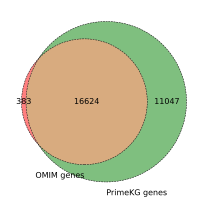

In [154]:
fig, ax = plt.subplots(1, 1,figsize=(3,3),)
subsets = [
    set(omim_genes.mimLabel),
    set(primekg.get_nodes_by_source('NCBI').name)
]

p = venn2(
    subsets,
    set_labels=(
        'OMIM genes',
        'PrimeKG genes',
    ),
    set_colors=('r', 'g'), 
    alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn2_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);

fig.tight_layout()
plt.show()

___
missing genes!

In [157]:
omim_genes_missing = list(
    set(omim_genes.mimLabel) - set(primekg.get_nodes_by_source('NCBI').name)
)
omim_genes_missing.sort()

In [158]:
len(omim_genes_missing)

383

<div class="alert alert-block alert-warning"> <b>Warning:</b> I'm not sure why these genes are missing in PrimeKG. These can be added in future revisions. </div>

In [160]:
omim_genes_missing[:10]

['A11',
 'ACPS',
 'ACTMAP',
 'ACYL-CoA THIOESTERASE 7-LIKE',
 'ADISSP',
 'AFG2A',
 'AFG2B',
 'AIRIM',
 'AIRN',
 'AL-A1']

e.g. this gene is available in NCBI 

ACTMAP – https://www.ncbi.nlm.nih.gov/gene/284325

___

cleaning ...

In [161]:
omim_genes_v2 = omim_genes.query(f'mimLabel not in {omim_genes_missing}').reset_index(drop=True)

___

In [162]:
gene_OMIM_kg = build_KG(
    indices = omim_genes_v2.index,
    relation = 'mim_gene',
    display_relation= 'linked to',

    x_id = omim_genes_v2['mimNumber'].astype(int),
    x_type = omim_genes_v2['mimType'].to_list(),
    x_name = omim_genes_v2['mimLabel'].to_list(),
    x_source = 'OMIM',

    y_id = '',
    y_type = '',
    y_name = '',
    y_source = 'NCBI'
)

add `y_index`, `y_type`, and `y_name` info

In [167]:
gene_OMIM_kg.df['y_index'] = primekg.get_nodes_by_source('NCBI').set_index('name').loc[
    gene_OMIM_kg.df.x_name,:].index.to_list()

In [168]:
gene_OMIM_kg.df['y_type'] = primekg.get_nodes_by_source('NCBI').set_index('name').loc[
    gene_OMIM_kg.df.x_name,'type'].to_list()

In [169]:
gene_OMIM_kg.df['y_name'] = primekg.get_nodes_by_source('NCBI').set_index('name').loc[
    gene_OMIM_kg.df.x_name,:].index.to_list()

In [174]:
gene_OMIM_kg.df.head()

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source,y_index
0,mim_gene,linked to,100640,gene,ALDH1A1,OMIM,,gene/protein,ALDH1A1,NCBI,ALDH1A1
1,mim_gene,linked to,100660,gene,ALDH3A1,OMIM,,gene/protein,ALDH3A1,NCBI,ALDH3A1
2,mim_gene,linked to,100670,gene,ALDH1B1,OMIM,,gene/protein,ALDH1B1,NCBI,ALDH1B1
3,mim_gene,linked to,100678,gene,ACAT2,OMIM,,gene/protein,ACAT2,NCBI,ACAT2
4,mim_gene,linked to,100690,gene,CHRNA1,OMIM,,gene/protein,CHRNA1,NCBI,CHRNA1


#### 2.2 Phenotype-Gene Relationships

In [170]:
#omim_tools.get_omim_phenotype_info(data_omim,'approvedGeneSymbols')

In [171]:
omim_pheno_gene = [] 

for mim_1, phenotypeMapList in omim_tools.get_omim_info(data_omim,'phenotypeMapList'):
    for pm in phenotypeMapList:
        mim_2 = str(pm['phenotypeMap']['mimNumber'])
        omim_pheno_gene.append((mim_1, mim_2))

omim_pheno_gene = pd.DataFrame(omim_pheno_gene,columns=['mim_1','mim_2'])

___

In [172]:
mim2gene.query(
    f'mimNumber in {omim_pheno_gene.mim_2.to_list()}'
).groupby(['mimType']).size()

mimType
gene              4764
gene/phenotype      17
phenotype           20
dtype: int64

In [173]:
mim2gene.query(
    f'mimNumber in {omim_pheno_gene.mim_1.to_list()}'
).groupby(['mimType','geneSymbol']).size()

mimType                   geneSymbol
phenotype                               6419
predominantly phenotypes                   6
dtype: int64

___

make the sub-graph:

In [176]:
pheno_gene_OMIM_kg = build_KG(
    indices = omim_pheno_gene.index,
    relation = 'phenotype_map', # mim_mim'
    display_relation= 'associated with',

    x_id = omim_pheno_gene['mim_1'].astype(int),
    x_type = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_1'],'mimType'].to_list(),
    x_name = '',
    x_source = 'OMIM',

    y_id = omim_pheno_gene['mim_2'].astype(int),
    y_type = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_2'],'mimType'].to_list(),
    y_name = '',
    y_source = 'OMIM'
)

___
add `x_name` info

In [180]:
sum(pheno_gene_OMIM_kg.df.x_type == 'gene')

0

okay, non of `x` nodes are genes! I'll label them with full title ... (I noticed some phenotype abbreviation didn't make sense so I continue with full title)

In [182]:
pheno_gene_OMIM_kg.df['x_name'] = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_1'],'mimTitle'].to_list()

___
add `y_name` info

In [184]:
pheno_gene_OMIM_kg.df.groupby('y_type').size()# == 'gene'

y_type
gene              7194
gene/phenotype      45
phenotype           20
dtype: int64

Most `y` nodes are genes so I just use the `mimLabel` column to label them ...

In [185]:
pheno_gene_OMIM_kg.df['y_name'] = mim_meta.set_index('mimNumber').loc[omim_pheno_gene['mim_2'],'mimLabel'].to_list()

In [186]:
pheno_gene_OMIM_kg.df.head()

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
0,phenotype_map,associated with,100100,phenotype,PRUNE BELLY SYNDROME,OMIM,118494,gene,CHRM3,OMIM
1,phenotype_map,associated with,100300,phenotype,ADAMS-OLIVER SYNDROME 1,OMIM,610911,gene,ARHGAP31,OMIM
2,phenotype_map,associated with,100800,phenotype,ACHONDROPLASIA,OMIM,134934,gene,FGFR3,OMIM
3,phenotype_map,associated with,101600,phenotype,PFEIFFER SYNDROME,OMIM,136350,gene,FGFR1,OMIM
4,phenotype_map,associated with,101600,phenotype,PFEIFFER SYNDROME,OMIM,176943,gene,FGFR2,OMIM


### 3.OMIM-OMIMPS

In [187]:
pheno_series = omim_tools.get_omim_phenotype_info(data_omim,'phenotypicSeriesNumber')

some values in `phenotypicSeriesNumber` needs extra data cleaning :)

In [188]:
pheno_series[pheno_series.phenotypicSeriesNumber.str.contains(',')].head()

,mimNumber,phenotypicSeriesNumber
61,615911,"PS105400,PS105550"
62,619141,"PS105400,PS105550"
63,616439,"PS105400,PS105550"
64,105550,"PS105400,PS105550"
65,619132,"PS105400,PS105550"


In [189]:
pheno_series_v2 = []

for _,mim_num,mim_ps_num in pheno_series.itertuples():
    if ',' in mim_ps_num:
        for mim_ps_num_iter in mim_ps_num.split(','):
            pheno_series_v2.append((mim_num,mim_ps_num_iter))
    else:
        pheno_series_v2.append((mim_num,mim_ps_num))

pheno_series_v2 = pd.DataFrame(pheno_series_v2,columns=pheno_series.columns)

___

make the sub-graph:

In [191]:
PS_OMIM_kg = build_KG(
    indices = pheno_series_v2.index,
    relation = 'mim_phenotypic_series',
    display_relation= 'members',

    x_id = pheno_series_v2['mimNumber'].astype(int),
    x_type = mim_meta.set_index('mimNumber').loc[pheno_series_v2['mimNumber'],'mimType'].to_list(),
    x_name = mim_meta.set_index('mimNumber').loc[pheno_series_v2['mimNumber'],'mimTitle'].to_list(),
    x_source = 'OMIM',

    y_id = pheno_series_v2['phenotypicSeriesNumber'],
    y_type = 'phenotypic_series',
    y_name = mimPS_Titles.set_index('Phenotypic Series number').loc[pheno_series_v2.phenotypicSeriesNumber,'Phenotypic Series Title'].to_list(),
    y_source = 'OMIMPS'
)

In [194]:
PS_OMIM_kg.df.groupby('x_type').size()

x_type
phenotype    4111
dtype: int64

In [196]:
PS_OMIM_kg.df.head()

,relation,display_relation,x_id,x_type,x_name,x_source,y_id,y_type,y_name,y_source
0,mim_phenotypic_series,members,100300,phenotype,ADAMS-OLIVER SYNDROME 1,OMIM,PS100300,phenotypic_series,Adams-Oliver syndrome,OMIMPS
1,mim_phenotypic_series,members,616028,phenotype,ADAMS-OLIVER SYNDROME 5,OMIM,PS100300,phenotypic_series,Adams-Oliver syndrome,OMIMPS
2,mim_phenotypic_series,members,615297,phenotype,ADAMS-OLIVER SYNDROME 4,OMIM,PS100300,phenotypic_series,Adams-Oliver syndrome,OMIMPS
3,mim_phenotypic_series,members,614814,phenotype,ADAMS-OLIVER SYNDROME 3,OMIM,PS100300,phenotypic_series,Adams-Oliver syndrome,OMIMPS
4,mim_phenotypic_series,members,614219,phenotype,ADAMS-OLIVER SYNDROME 2,OMIM,PS100300,phenotypic_series,Adams-Oliver syndrome,OMIMPS


### 4.HPO-OMIM-sets

In [197]:
# get_omim_for_hpo_term(1507)

In [199]:
hpo_omim_map = []

for hpo_id in primekg.get_nodes_by_source('HPO').id:
    hpo_mim_ids = get_omim_for_hpo_term(int(hpo_id))
    if len(hpo_mim_ids) > 1:
        for mim_id in hpo_mim_ids:
            hpo_omim_map.append((hpo_id,mim_id))

hpo_omim_map = pd.DataFrame(hpo_omim_map,columns=['HPO','OMIM'])

In [200]:
hpo_omim_map.OMIM.isin(mim_meta.mimNumber).all()

True

good!

___

make the sub-graph:

In [205]:
HPO_OMIM_kg = build_KG(
    indices = hpo_omim_map.index,
    relation = 'mim_phenotype',
    display_relation= 'associated with',

    x_id = hpo_omim_map.OMIM.astype(int),
    x_type = mim_meta.set_index('mimNumber').loc[hpo_omim_map.OMIM,'mimType'].to_list(),
    x_name = mim_meta.set_index('mimNumber').loc[hpo_omim_map.OMIM,'mimTitle'].to_list(),
    x_source = 'OMIM',

    y_id = primekg.get_nodes_by_source('HPO').set_index('id').loc[hpo_omim_map.HPO.to_list(),].index.to_list(),
    y_type = primekg.get_nodes_by_source('HPO').set_index('id').loc[hpo_omim_map.HPO.to_list(),'type'].to_list(),
    y_name = primekg.get_nodes_by_source('HPO').set_index('id').loc[hpo_omim_map.HPO.to_list(),'name'].to_list(),
    y_source = 'HPO'
)

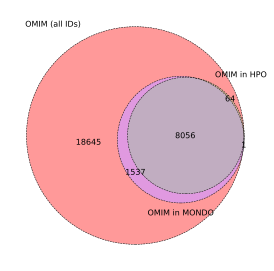

In [207]:
fig, ax = plt.subplots(1, 1,figsize=(4,4),)
subsets = [
    set(mim2gene.mimNumber), 
    set(HPO_OMIM_kg.df.x_id.astype(str)),
    set(mondo_omim_terms['omim'].str.replace('OMIM:','').astype(int).astype(str)),
]


p = venn3(
    subsets,
    set_labels=(
        'OMIM (all IDs)',
        'OMIM in HPO',
        'OMIM in MONDO'
    ),
    set_colors=('r', 'g', 'b'), 
    # alpha = 0.5,
    ax=ax);

for text in p.set_labels:
    text.set_fontsize(8)
for x in range(len(p.subset_labels)):
    if p.subset_labels[x] is not None:
        p.subset_labels[x].set_fontsize(8)

venn3_circles(
    subsets,
    linestyle='dashed', linewidth=.5, color='k',ax=ax);

fig.tight_layout()
plt.show()

### concat all subgraphs of OMIM-kg

In [209]:
OMIM_kg = KnowledgeGraph(
    pd.concat([
        Mondo_OMIM_kg.df, Mondo_OMIMPS_kg.df, 
        gene_OMIM_kg.df, pheno_gene_OMIM_kg.df,
        PS_OMIM_kg.df,
        HPO_OMIM_kg.df
    ]).reset_index(drop=True)
)

<div class="alert alert-block alert-warning"> <b>Note:</b> Some columns (e.g. `x_id`/`y_id`) should be reconsidered by using harmonized integration of the two graphs.</div>

## Report

___
[@ayushnoori](https://github.com/ayushnoori) comment ([link](https://github.com/mims-harvard/PrimeKG/pull/12#issuecomment-1871463218)):
> - It would be super helpful if you could prepare a summary of the changes to PrimeKG by adding OMIM nodes: e.g., the number of OMIM phenotypes already in PrimeKG, the number of OMIM phenotypes you add, the number of new edges added (stratified by edge type), the original vs. final edge counts, etc. Your Venn diagrams in `append_omim.ipynb` look fantastic – it would be helpful to have them in a single document with descriptions so we can review together before merging this PR.



#### basic stats

In [211]:
print(f'# of new edges: {OMIM_kg.df.shape[0]}')
print(f'# of new node: {OMIM_kg.get_nodes_by_source("OMIM").shape[0]}')

# of new edges: 612282
# of new node: 32866


In [213]:
OMIM_kg.df.groupby('relation').size()

relation
mim_disease                        9599
mim_gene                          16636
mim_phenotype                    574128
mim_phenotypic_series              4111
mim_phenotypic_series_disease       549
phenotype_map                      7259
dtype: int64

In [214]:
OMIM_kg.df.groupby('display_relation').size()

display_relation
associated with    581387
linked to           26784
members              4111
dtype: int64

## Extend PrimeKG with OMIM-KG

In [216]:
primekg_plus = KnowledgeGraph(
    pd.concat([primekg.df, OMIM_kg.df]).reset_index(drop=True)
)

<div class="alert alert-block alert-warning"> <b>Note:</b> The current `relations` can be more in depth in later revisions. </div>

# 

In [218]:
%load_ext watermark

In [219]:
%watermark

Last updated: 2023-12-29T02:29:31.024160-08:00

Python implementation: CPython
Python version       : 3.10.9
IPython version      : 8.11.0

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 23.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [220]:
%watermark --iversions

pandas    : 1.4.2
sys       : 3.10.9 (main, Jan 11 2023, 09:18:20) [Clang 14.0.6 ]
matplotlib: 3.5.1
igraph    : 0.9.10
re        : 2.2.1
numpy     : 1.21.5

